<center><img src="img/logo_hse.png" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 1: Генеративные сети</center></h2>

# Введение

Не все же нам MNIST генерировать. Давайте посмотрим, как генеративные модели могут использоваться не только для развлечения. Поехали!

Немного вступления и мотивации, для чего мы хотим обучать модель.

## MAGIC – Major Atmospheric Gamma Imaging Cherenkov Telescope

MAGIC (Major Atmospheric Gamma Imaging Cherenkov) - это система, состоящая из двух черенковских телескопов диаметром 17 м. Они предназначены для наблюдения гамма-лучей от галактических и внегалактических источников в диапазоне очень высоких энергий (от 30 ГэВ до 100 ТэВ).

MAGIC позволил открыть и исследовать новые классы источников гамма-излучения, таких как, например, пульсары и гамма-всплески (GRB).

<center><img src="img/magic1.jpg" width="1000"></center>

Источник: https://magic.mpp.mpg.de/

Youtube video: https://youtu.be/mjcDSR2vSU8

#### Ок, давайте зафиксируем. Какой-то крутой телескоп позволяет открыть новые виды излучения. Идем дальше.

## Частицы из космоса

Космические частицы, $\gamma$-кванты (фотоны) и адроны (протоны), взаимодействуют с атмосферой и порождают ливни вторичных частиц. Двигаясь с околосветовой скоростью, эти частицы излучают Черенковское излучение. Телескопы фотографируют это излучение.
#### По фотографиям можно определить тип частицы из космоса: фотон или протон. Знакомая формулировка задачи, не правда ли?

<center><img src="img/shower.jpg" width="500"></center>

## Фотографии

Задача атмосферного черенковского телескопа - получить изображение ливня путем измерения черенковского света от частиц ливня. Это изображение представляет собой геометрическую проекцию ливня на детектор. Для анализа этих изображений были введены параметры изображения или так называемые параметры Хилласа. Ниже пример такой фотографии.

<center><img src="img/geo.jpg" width="400"></center>

#### Итак, каждая фотография описывается набором параметров, которые за нас считает телескоп. А что там с двумя видами частиц?

## Фотоны vs адронов

Изображения для $\gamma$-квантов (фотонов) и адронов (протонов) отличаются по форме кластеров. Астрономы используют модели машинного обучения для классификации этих изображений. Получение каждого такого изображения - дорогое удовольствие!


<center><img src="img/gamma_p.png" width="600"></center>

Для обучения моделей ученые искусственно генерируют такие изображения для каждого типа частиц с помощью сложных физических симуляторов.

#### Итак, давайте сэкономим денег для ученых и сгенерируем хороших фотографий разных частиц. Используем для этого GAN и диффузионные модели!

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Данные

Будем использовать данные телескопа MAGIC из UCI репозитория https://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope. Каждый объект в данных - параметры одного изображения кластера и метка этого кластера (фотон или адрон):


0. Length: major axis of ellipse [mm]
1. Width: minor axis of ellipse [mm]
2. Size: 10-log of sum of content of all pixels [in #phot]
3. Conc: ratio of sum of two highest pixels over fSize [ratio]
4. Conc1: ratio of highest pixel over fSize [ratio]
5. Asym: distance from highest pixel to center, projected onto major axis [mm]
6. M3Long: 3rd root of third moment along major axis [mm]
7. M3Trans: 3rd root of third moment along minor axis [mm]
8. Alpha: angle of major axis with vector to origin [deg]
9. Dist: distance from origin to center of ellipse [mm]
10. class: g,h # gamma (signal), hadron (background)

In [2]:
# read data
names = np.array(
    [
        "Length",
        "Width",
        "Size",
        "Conc",
        "Conc1",
        "Asym",
        "M3Long",
        "M3Trans",
        "Alpha",
        "Dist",
        "class",
    ]
)
data = pd.read_csv("magic04.data", header=None)
data.columns = names
print(data.shape)
data.head()

(19020, 11)


,Length,Width,Size,Conc,Conc1,Asym,M3Long,M3Trans,Alpha,Dist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


# Постановка задачи

Ваша задача заключается в том, чтобы с помощью генеративно-состязательных сетей научиться генерировать параметры кластеров на изображениях телескопа для каждого типа частиц (фотона или адрона):

- $X$ - матрица реальных объектов, которые нужно начиться генерировать;
- $y$ - метки классов, которые будем использовать как условие при генерации.

In [3]:
# параметры кластеров на изображениях
X = data[names[:-1]].values
X = np.abs(X)

# метки классов
labels = data[names[-1]].values
y = np.ones((len(labels), 1))
y[labels == "h"] = 0

In [4]:
# примеры
X[:2]

array([[2.87967e+01, 1.60021e+01, 2.64490e+00, 3.91800e-01, 1.98200e-01,
        2.77004e+01, 2.20110e+01, 8.20270e+00, 4.00920e+01, 8.18828e+01],
       [3.16036e+01, 1.17235e+01, 2.51850e+00, 5.30300e-01, 3.77300e-01,
        2.62722e+01, 2.38238e+01, 9.95740e+00, 6.36090e+00, 2.05261e+02]])

In [5]:
# примеры
y[:10]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [6]:
# все возможные значения
np.unique(y)

array([0., 1.])

# Визуализация данных

Каждое изображение описывается 10 параметрами. Давайте построим распределения значений каждого параметра для каждого типа частиц.

In [7]:
def plot_hists(X1, X2, names, label1, label2, bins=np.linspace(-3, 3, 61)):
    plt.figure(figsize=(5 * 4, 5 * 2))
    for i in range(X1.shape[1]):
        plt.subplot(3, 4, i + 1)
        plt.grid()
        plt.hist(X1[:, i], bins=bins, alpha=0.3, label=label1, color="C4")
        plt.hist(X2[:, i], bins=bins, alpha=0.3, label=label2, color="C0")
        plt.xlabel(names[i], size=14)
        plt.legend(loc="best")
    plt.tight_layout()

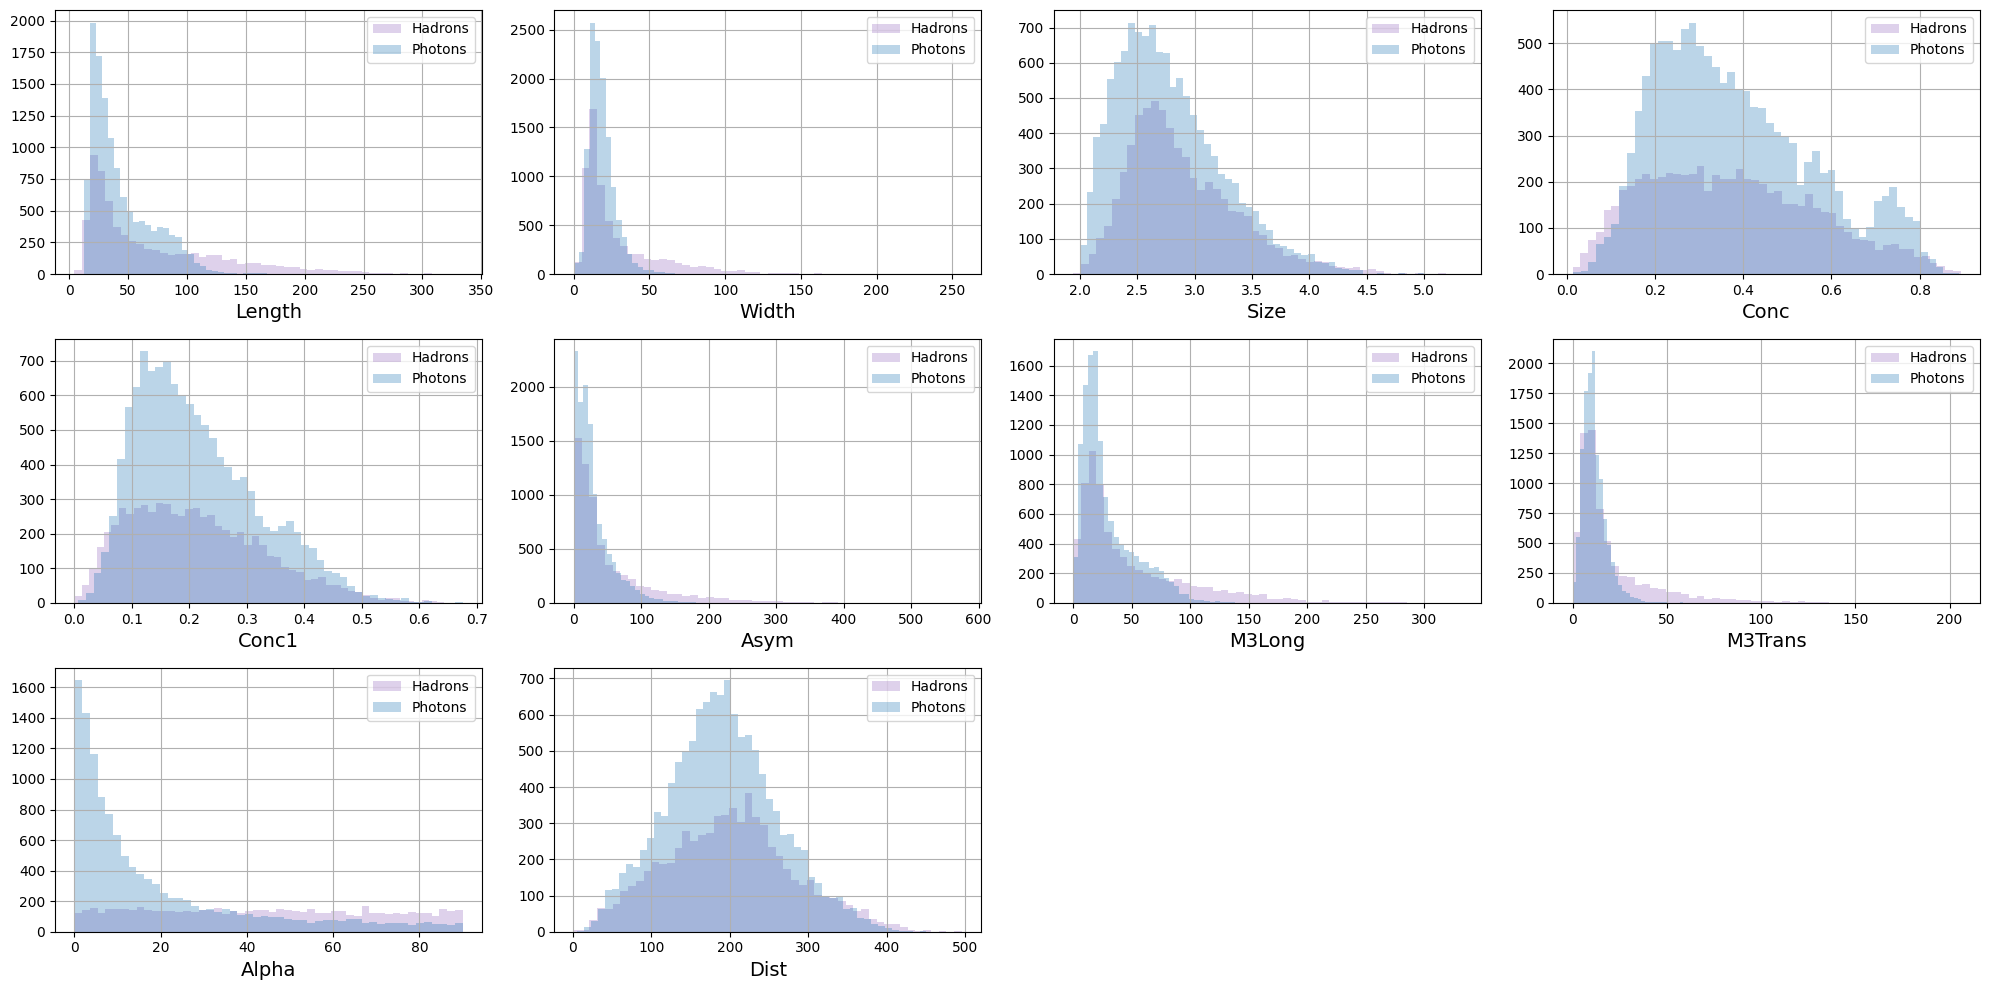

In [8]:
plot_hists(
    X[y[:, 0] == 0], X[y[:, 0] == 1], names, label1="Hadrons", label2="Photons", bins=50
)

# Предобработка данных

Из графика видим, что распределения для многих признаков имеют тяжелые хвосты. Это делает обучение генеративных моделей тяжелее. Поэтому нужно как-то преобразовать данные, чтобы убрать эти тяжелые хвосты.

# Обучающая и тестовая выборки

In [9]:
from sklearn.model_selection import train_test_split

# train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.5, shuffle=True, random_state=11
)

## Задание 1 (0.2 балла)

Проиллюстрируйте распределение целевой переменной внутри train и test выборки. Совпадает ли оно? Есть ли идеи почему так?

__Подсказка__: посмотрите на клеточку с разделением данных

__Ответ:__ Распределение совпадает, потому что при train_test_split мы делали stratify=y, и оно как раз распределяет данные так, чтобы распределение значений y совпадало между выборками

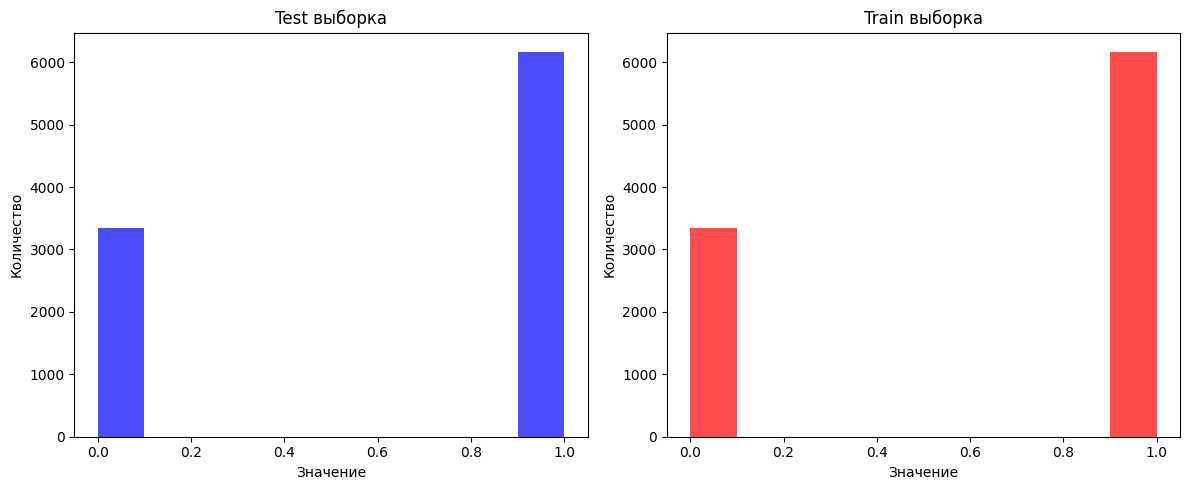

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(y_test, color='blue', alpha=0.7)
axes[0].set_xlabel('Значение')
axes[0].set_ylabel('Количество')
axes[0].set_title('Test выборка')

axes[1].hist(y_train, color='red', alpha=0.7)
axes[1].set_xlabel('Значение')
axes[1].set_ylabel('Количество')
axes[1].set_title('Train выборка')

plt.tight_layout()
plt.show()

## Задание 2 (0.8 балл)

Используя функцию `sklearn.preprocessing.QuantileTransformer` трансформируйте входные данные `X_train` и `X_test`. Это преобразование делает так, чтобы распределение каждого параметра было нормальным. Описание функции доступно по [ссылке](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html). Используйте значение параметра `output_distribution='normal'`.

In [12]:
from sklearn.preprocessing import QuantileTransformer

QT = QuantileTransformer(output_distribution='normal', random_state=11)
X_train = QT.fit_transform(X_train)
X_test = QT.transform(X_test)

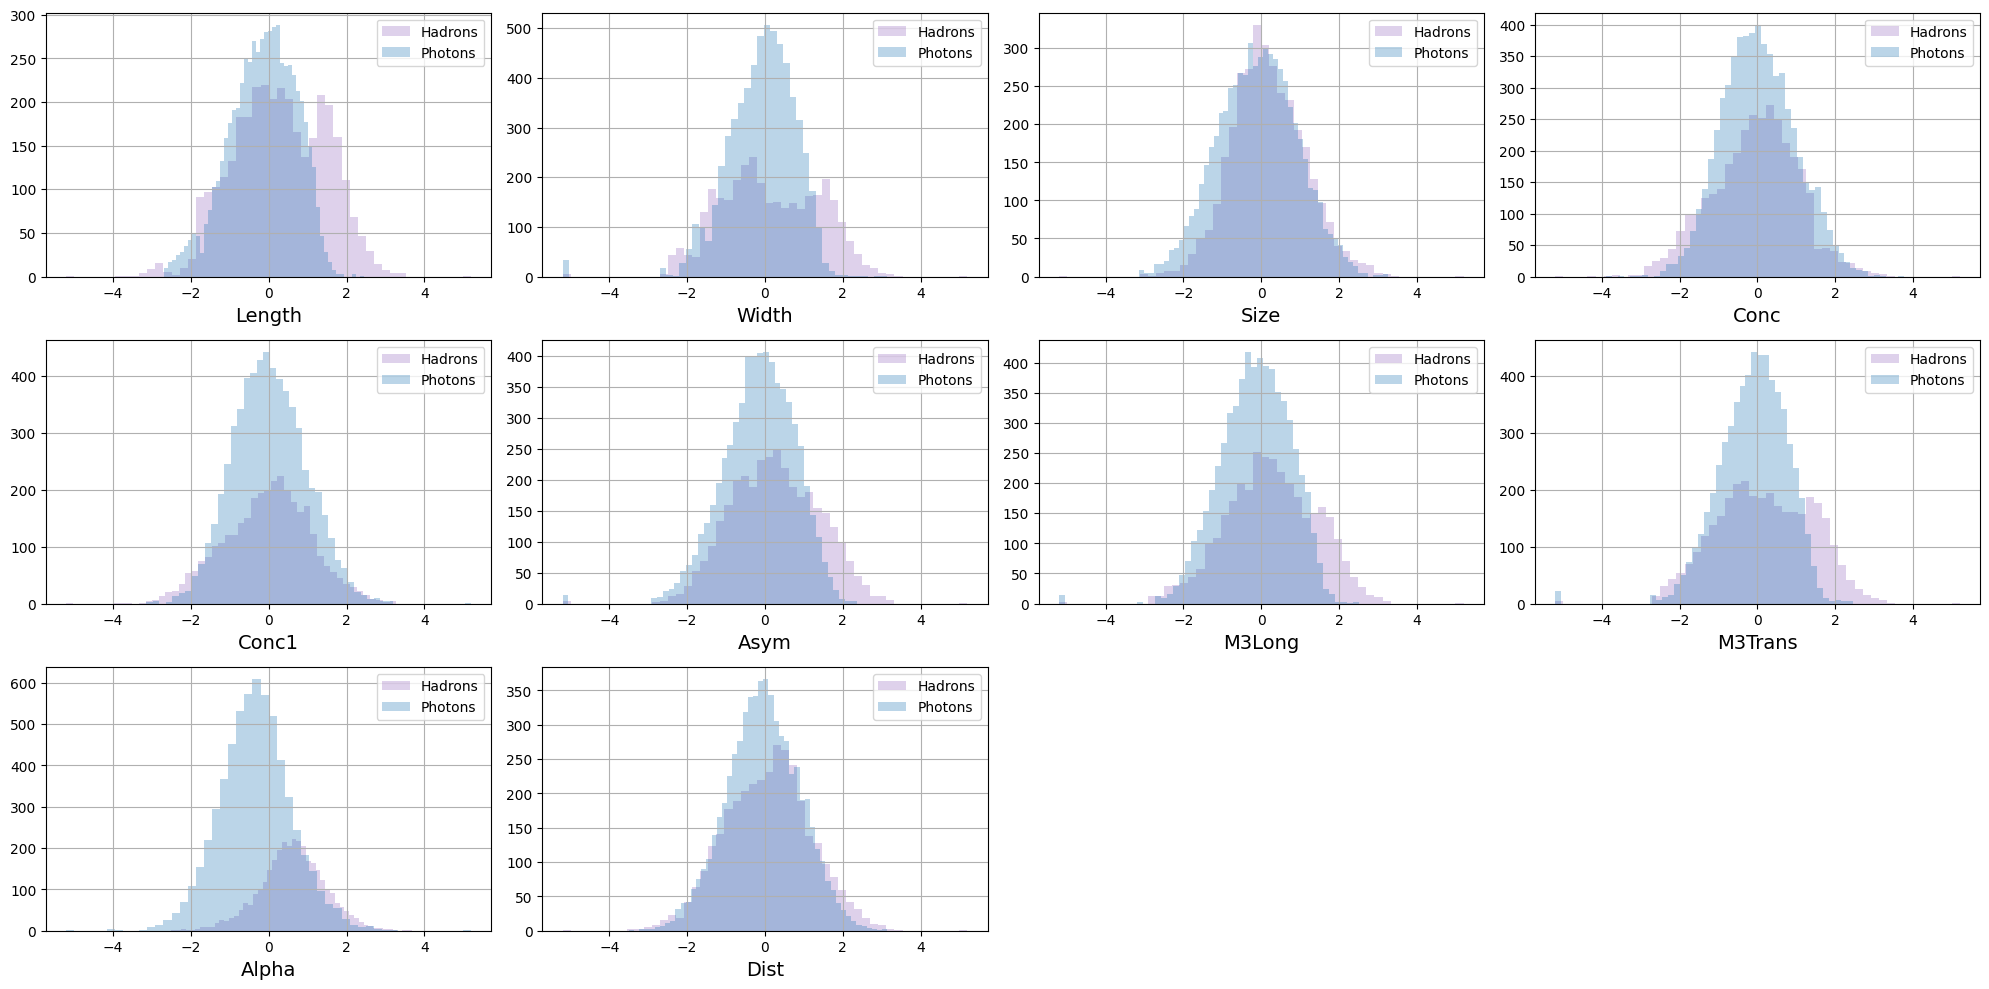

In [13]:
plot_hists(
    X_train[y_train[:, 0] == 0],
    X_train[y_train[:, 0] == 1],
    names,
    label1="Hadrons",
    label2="Photons",
    bins=50,
)

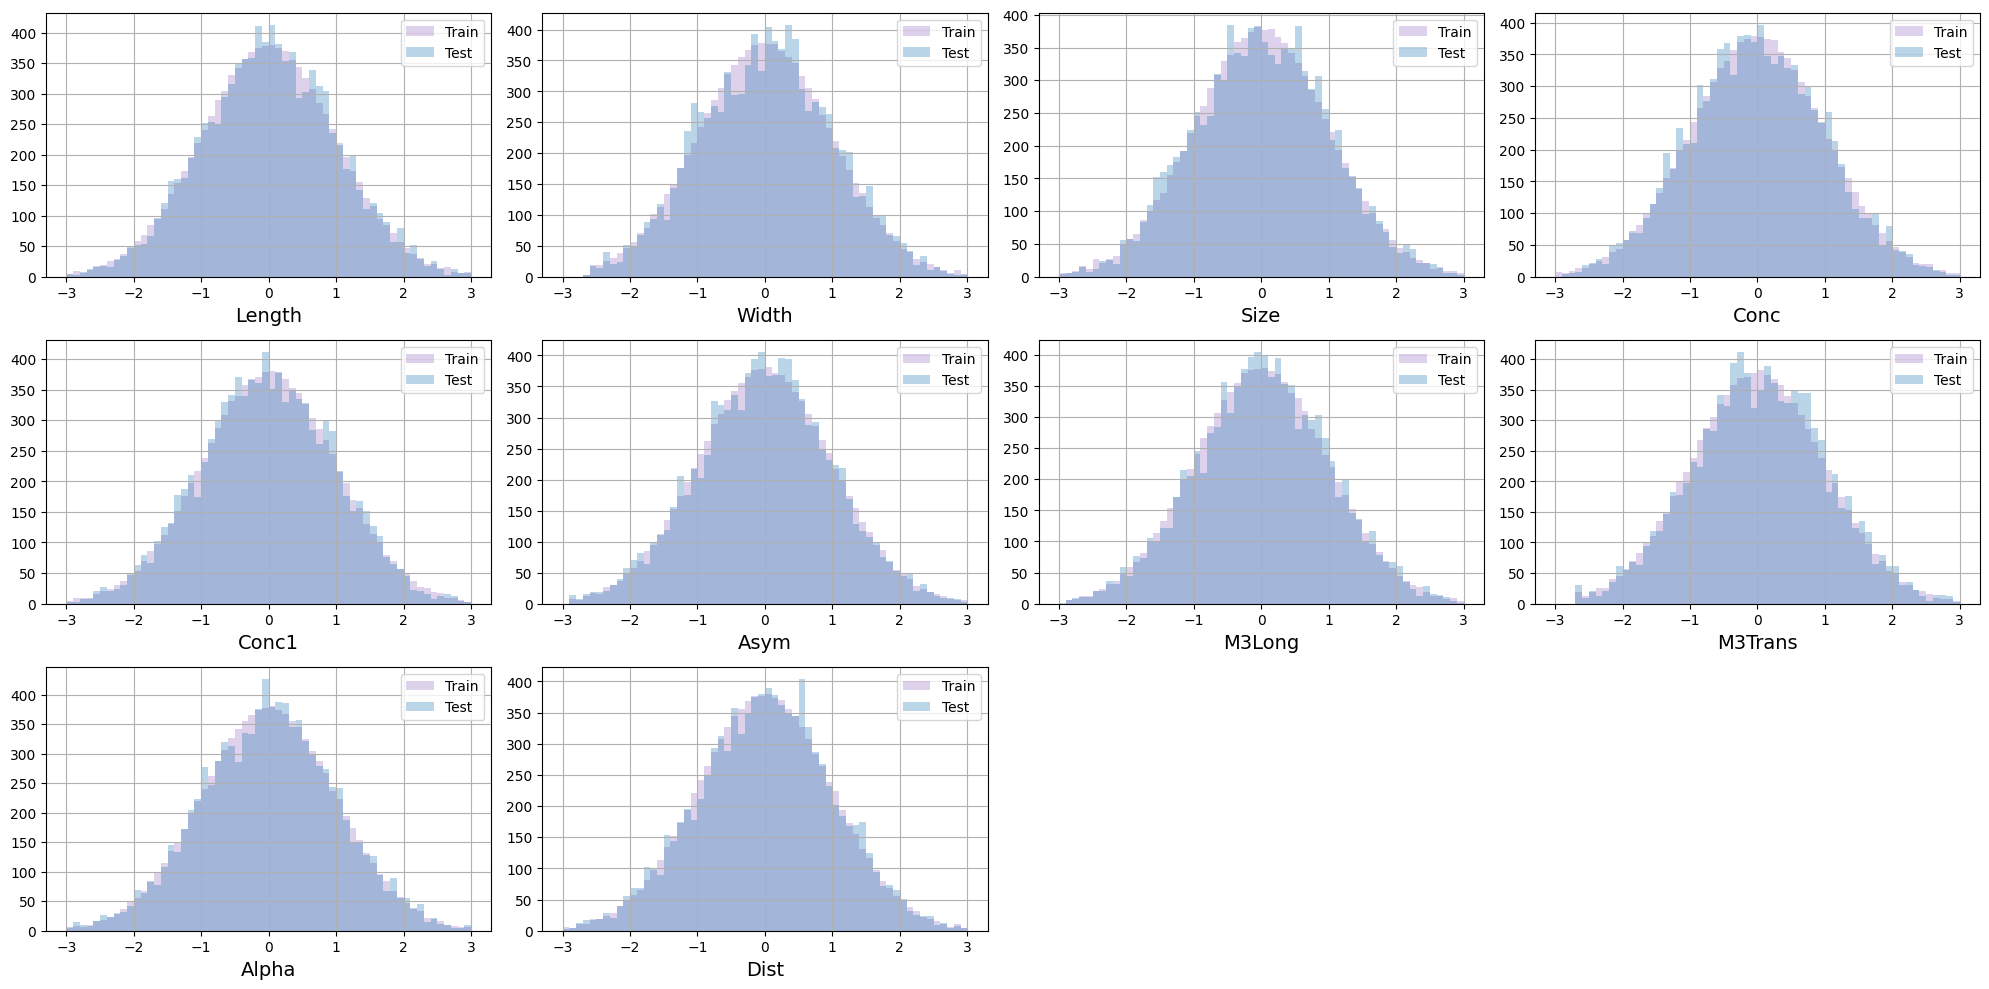

In [14]:
plot_hists(X_train, X_test, names, label1="Train", label2="Test")

# Conditional WGAN

Мы будем использовать `Conditional WGAN`, который изображен на рисунке. В качестве условия `y` мы будем использовать метку класса: **0** - адрон, **1** - фотон. Таким образом, мы будем сообщать генератору для какой частицы нужно генерировать параметры изображения.

<center><img src="img/cgan.png" width="800"></center>

Генератор $\hat{x} = G(z, y)$ будет принимать на вход шумовой вектор $z$ и вектор условий $y$, а выдавать будет сгенерированный (фейковый) вектор параметров $\hat{x}$.

Дискриминатор $D(x, y)$ будет принимать на вход вектор параметров $x$ и вектор условий $y$, а возвращать будет рациональное число.

Обучать `Conditional WGAN` будем с такой функцией потерь:

$$L(G, D) = -\frac{1}{n} \sum_{x_i \in X, y_i \in y} D(x_i, y_i) + \frac{1}{n} \sum_{z_i \in Z, y_i \in y} D(G(z_i, y_i), y_i) \to \max_G \min_D$$

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
DEVICE

device(type='cuda')

## Задание 3 (0.75 балла)

Реализуйте нейронную сеть для генератора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [17]:
class Generator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(Generator, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, n_outputs)
        )

    def forward(self, z, y):
        zy = torch.cat((z, y), dim=1)
        return self.net(zy)

## Задание 4 (0.5 балл)

Реализуйте функцию для генерации новый объектов $X$ по вектору условий $y$.

In [18]:
def generate(generator, y, latent_dim):
    z = torch.from_numpy(np.random.normal(0, 1, size=(y.shape[0], latent_dim))).float().to(DEVICE)
    y = torch.tensor(y, dtype=torch.int, device=DEVICE)
    X_fake = generator(z, y)
    return X_fake.cpu().detach().numpy()  # numpy

## Задание 5 (0.75 балла)

Реализуйте нейронную сеть для дискриминатора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Выходной слой.

Какая функция активации должна быть в конце работы модели и почему? А она вообще тут должна быть? Обоснуйте свой выбор.

In [19]:
class Discriminator(nn.Module):
    def __init__(self, n_inputs):
        super(Discriminator, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 1),
            nn.Sigmoid()
        )

    def forward(self, x, y):
        xy = torch.cat((x, y), dim=1)
        return self.net(xy)

## Задание 6 (0.5 балла)

Реализуйте функцию, которая принимала бы на вход набор сгенерированных и настоящих объектов, разбивала на train и test с учетом баланса классов (real и fake объектов), с соотношением 3 к 1, обучала модель логистической регрессии и градиентного бустинга, которые учились бы отличать настоящие объекты от фальшивых, после чего выводила бы accuracy score на отложенной выборке у обоих моделей.

Ответьте на вопрос: какое значение accuracy score нас бы удовлетворило больше всего? Почему?

__Ответ:__ как я понимаю, оптимальным значением должно быть 0.5, так как в таком случае дискриминатор не умеет различать настоящие и фейковые объекты и действует как случайный классификатор.

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

def other_agent_score(X_real, y_real, X_fake, y_fake):
    X = np.concatenate((X_real, X_fake), axis=0)
    y = np.concatenate((y_real, y_fake), axis=0)

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.5, shuffle=True, random_state=11)

    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    log_reg_score = accuracy_score(y_test, y_pred)

    grad_boosting = GradientBoostingClassifier()
    grad_boosting.fit(X_train, y_train)
    y_pred = grad_boosting.predict(X_test)
    boosting_score = accuracy_score(y_test, y_pred)

    print("Logistic regression score: " + str(log_reg_score))
    print("Boosting score: " + str(boosting_score))

## Задание 7 (1.5 балла)

Реализуйте класс для обучения генеративной модели.

- Уточнение 1: Нужно ограничивать веса дискриминатора. Для этого используйте `p.data.clamp_(-0.01, 0.01)`, где `p` веса дискриминатора. Зачем это делать можно посмотреть в оригинальной статье <https://arxiv.org/pdf/1701.07875.pdf>.
- Подсказка 1: `n_critic` - число итераций обучения дискриминатора на одну итерацию обучения генератора.
- Подсказка 2: Используйте `X_tensor = torch.tensor(X_numpy, dtype=torch.float, device=DEVICE)` для перевода numpy в тензор.

In [21]:
class Fitter(object):
    def __init__(
        self,
        generator,
        discriminator,
        batch_size=32,
        n_epochs=10,
        latent_dim=1,
        lr=0.0001,
        n_critic=5,
    ):

        self.generator = generator
        self.discriminator = discriminator
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic

        self.opt_gen = torch.optim.RMSprop(self.generator.parameters(), lr=self.lr)
        self.opt_disc = torch.optim.RMSprop(self.discriminator.parameters(), lr=self.lr)

        self.generator.to(DEVICE)
        self.discriminator.to(DEVICE)

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.generator.train(True)
        self.discriminator.train(True)

        self.loss_history = []

        # Fit GAN
        for epoch in range(self.n_epochs):
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):
                real_batch, cond_batch = real_batch.to(DEVICE), cond_batch.to(DEVICE)
                Z_noise = torch.normal(mean=0, std=1, size=(len(real_batch), self.latent_dim)).to(DEVICE)

                fake_batch = self.generator(Z_noise, cond_batch)

                input_data = torch.cat([real_batch, fake_batch], dim=0)
                input_conditions = torch.cat([cond_batch, cond_batch], dim=0)

                predictions = self.discriminator(input_data, input_conditions)

                real_preds, fake_preds = torch.split(predictions, len(cond_batch))

                if i % (self.n_critic + 1) == self.n_critic:
                    self.opt_gen.zero_grad()
                    gen_loss = torch.log(1 - fake_preds).mean()
                    gen_loss.backward()
                    self.opt_gen.step()
                else:
                    self.opt_disc.zero_grad()
                    disc_loss = -torch.log(real_preds).mean() - torch.log(1 - fake_preds).mean()
                    disc_loss.backward()
                    self.opt_disc.step()

                with torch.no_grad():
                    for param in self.discriminator.parameters():
                          param.data.clamp_(-0.01, 0.01)

            # caiculate and store loss after an epoch
            Z_noise = torch.normal(0, 1, (len(X_real), self.latent_dim)).to(DEVICE)
            X_fake = self.generator(Z_noise, y_cond)
            loss_epoch = torch.mean(self.discriminator(X_real, y_cond)) - torch.mean(
                self.discriminator(X_fake, y_cond)
            )
            self.loss_history.append(loss_epoch.detach().cpu())

            # Создайте выборку из 1000 объектов из X_train и 1000 сгенерированных объектов
            # И запустите работу фукнции other_agent_score

            if epoch % 20 == 0:
                print('epoch:', epoch)
                idx = torch.randperm(X_real.shape[0])[:1000]
                other_agent_score(X_real[idx].cpu().detach().numpy(), np.ones(1000), X_fake[idx].cpu().detach().numpy(), np.zeros(1000))

        print('epoch:', epoch)
        idx = torch.randperm(X_real.shape[0])[:1000]
        other_agent_score(X_real[idx].cpu().detach().numpy(), np.ones(1000), X_fake[idx].cpu().detach().numpy(), np.zeros(1000))
        # Turn off training
        self.generator.train(False)
        self.discriminator.train(False)

## Обучение
Обучим модель на данных.

In [22]:
%%time
latent_dim = 10
generator = Generator(n_inputs=latent_dim + y.shape[1], n_outputs=X_train.shape[1])
discriminator = Discriminator(n_inputs=X_train.shape[1] + y.shape[1])

fitter = Fitter(
    generator,
    discriminator,
    batch_size=50,
    n_epochs=200,
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=5,
)
fitter.fit(X_train, y_train)

epoch: 0
Logistic regression score: 0.572
Boosting score: 0.842
epoch: 20
Logistic regression score: 0.52
Boosting score: 0.647
epoch: 40
Logistic regression score: 0.555
Boosting score: 0.639
epoch: 60
Logistic regression score: 0.497
Boosting score: 0.545
epoch: 80
Logistic regression score: 0.483
Boosting score: 0.559
epoch: 100
Logistic regression score: 0.509
Boosting score: 0.565
epoch: 120
Logistic regression score: 0.539
Boosting score: 0.553
epoch: 140
Logistic regression score: 0.536
Boosting score: 0.546
epoch: 160
Logistic regression score: 0.518
Boosting score: 0.559
epoch: 180
Logistic regression score: 0.542
Boosting score: 0.568
epoch: 199
Logistic regression score: 0.503
Boosting score: 0.527
CPU times: user 2min 21s, sys: 3.38 s, total: 2min 24s
Wall time: 2min 26s


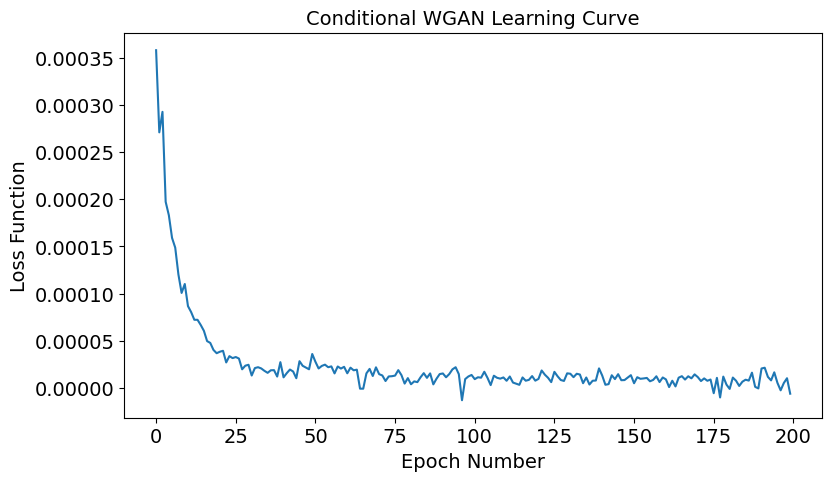

In [23]:
# WGAN learning curve
plt.figure(figsize=(9, 5))
plt.plot(fitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional WGAN Learning Curve", size=14)
plt.show()

## Задание 8 (0.5 балла)

Теперь сгенерируем фейковые матрицы `X_fake_train` и `X_fake_test`. Сравним их с матрицами реальных объектов `X_train` и `X_test`. Перед сравнением результатов сделайте обратное квантильное преобразование с помощью трансформера, который вы обучили в задании 2.

In [24]:
X_train = QT.inverse_transform(X_train)
X_test = QT.inverse_transform(X_test)

In [25]:
X_fake_train = generate(fitter.generator, y_train, latent_dim)
X_fake_train = QT.inverse_transform(X_fake_train)

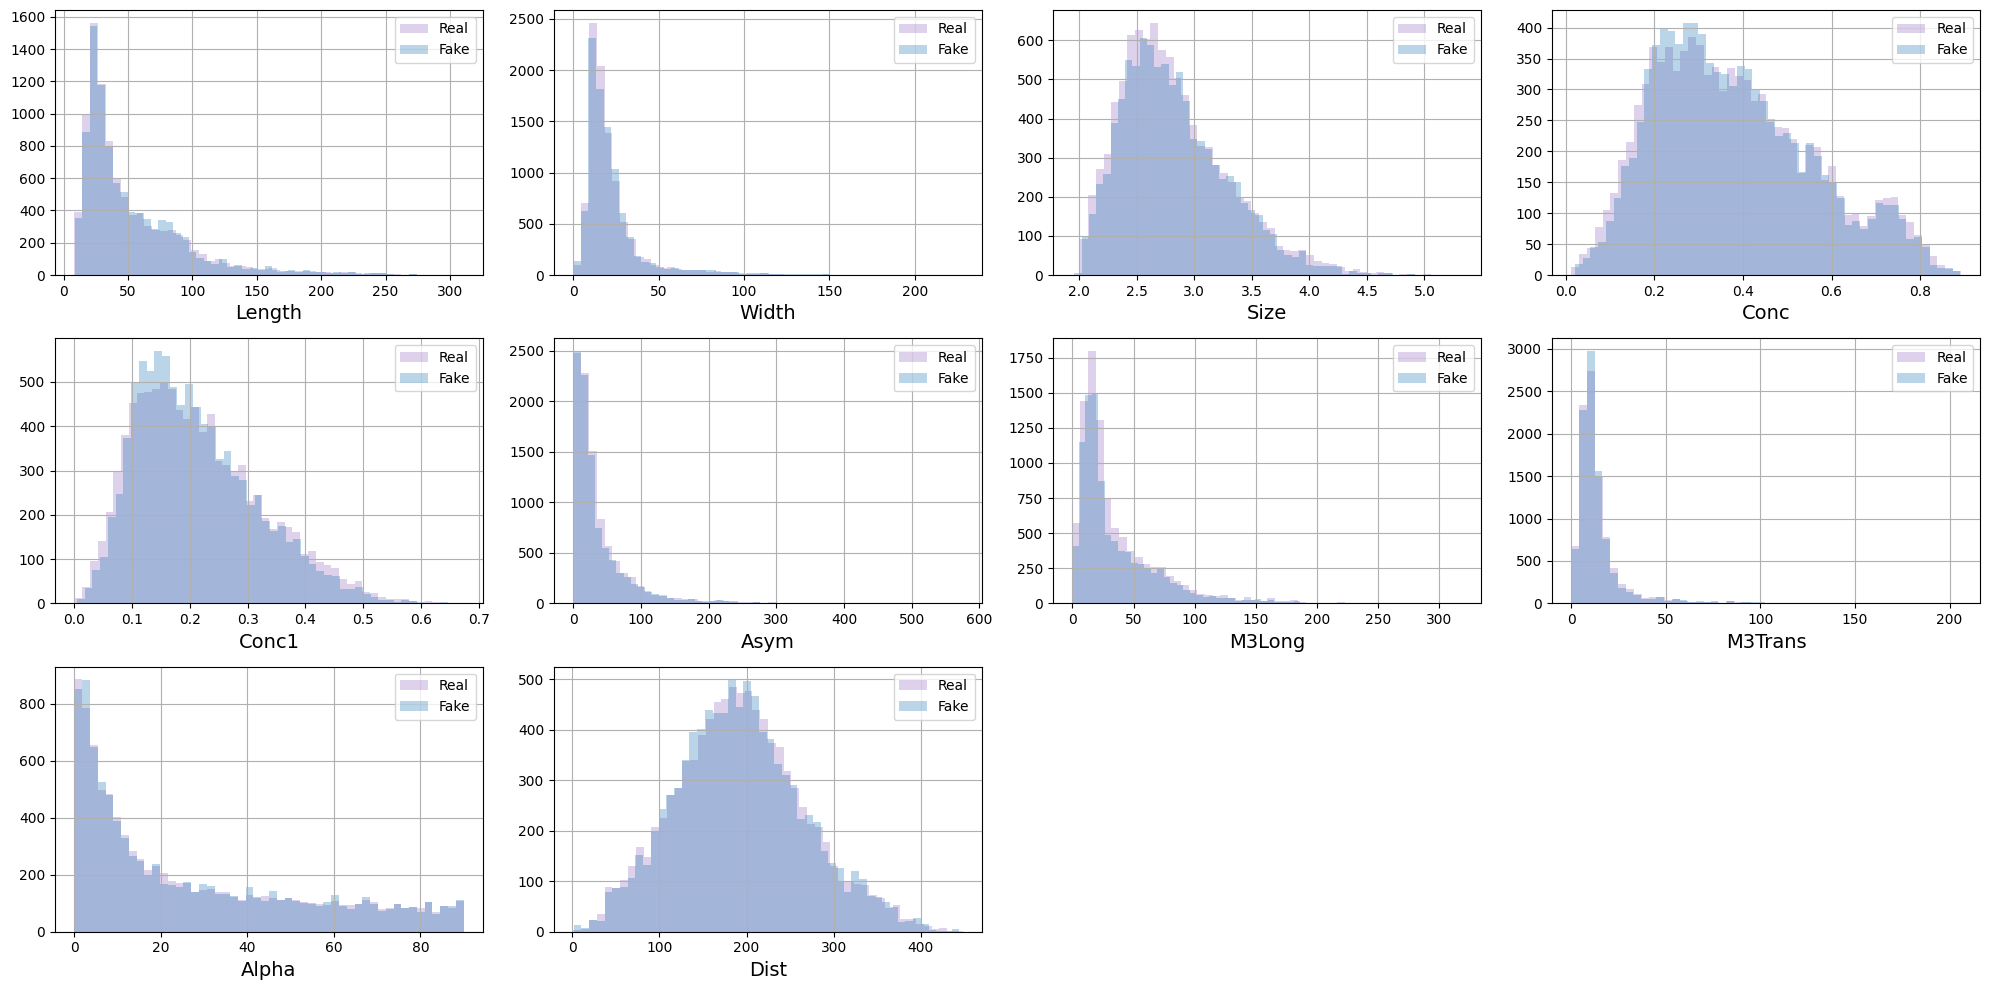

In [26]:
plot_hists(X_train, X_fake_train, names, label1="Real", label2="Fake", bins=50)

In [27]:
X_fake_test = generate(fitter.generator, y_test, latent_dim)
X_fake_test = QT.inverse_transform(X_fake_test)

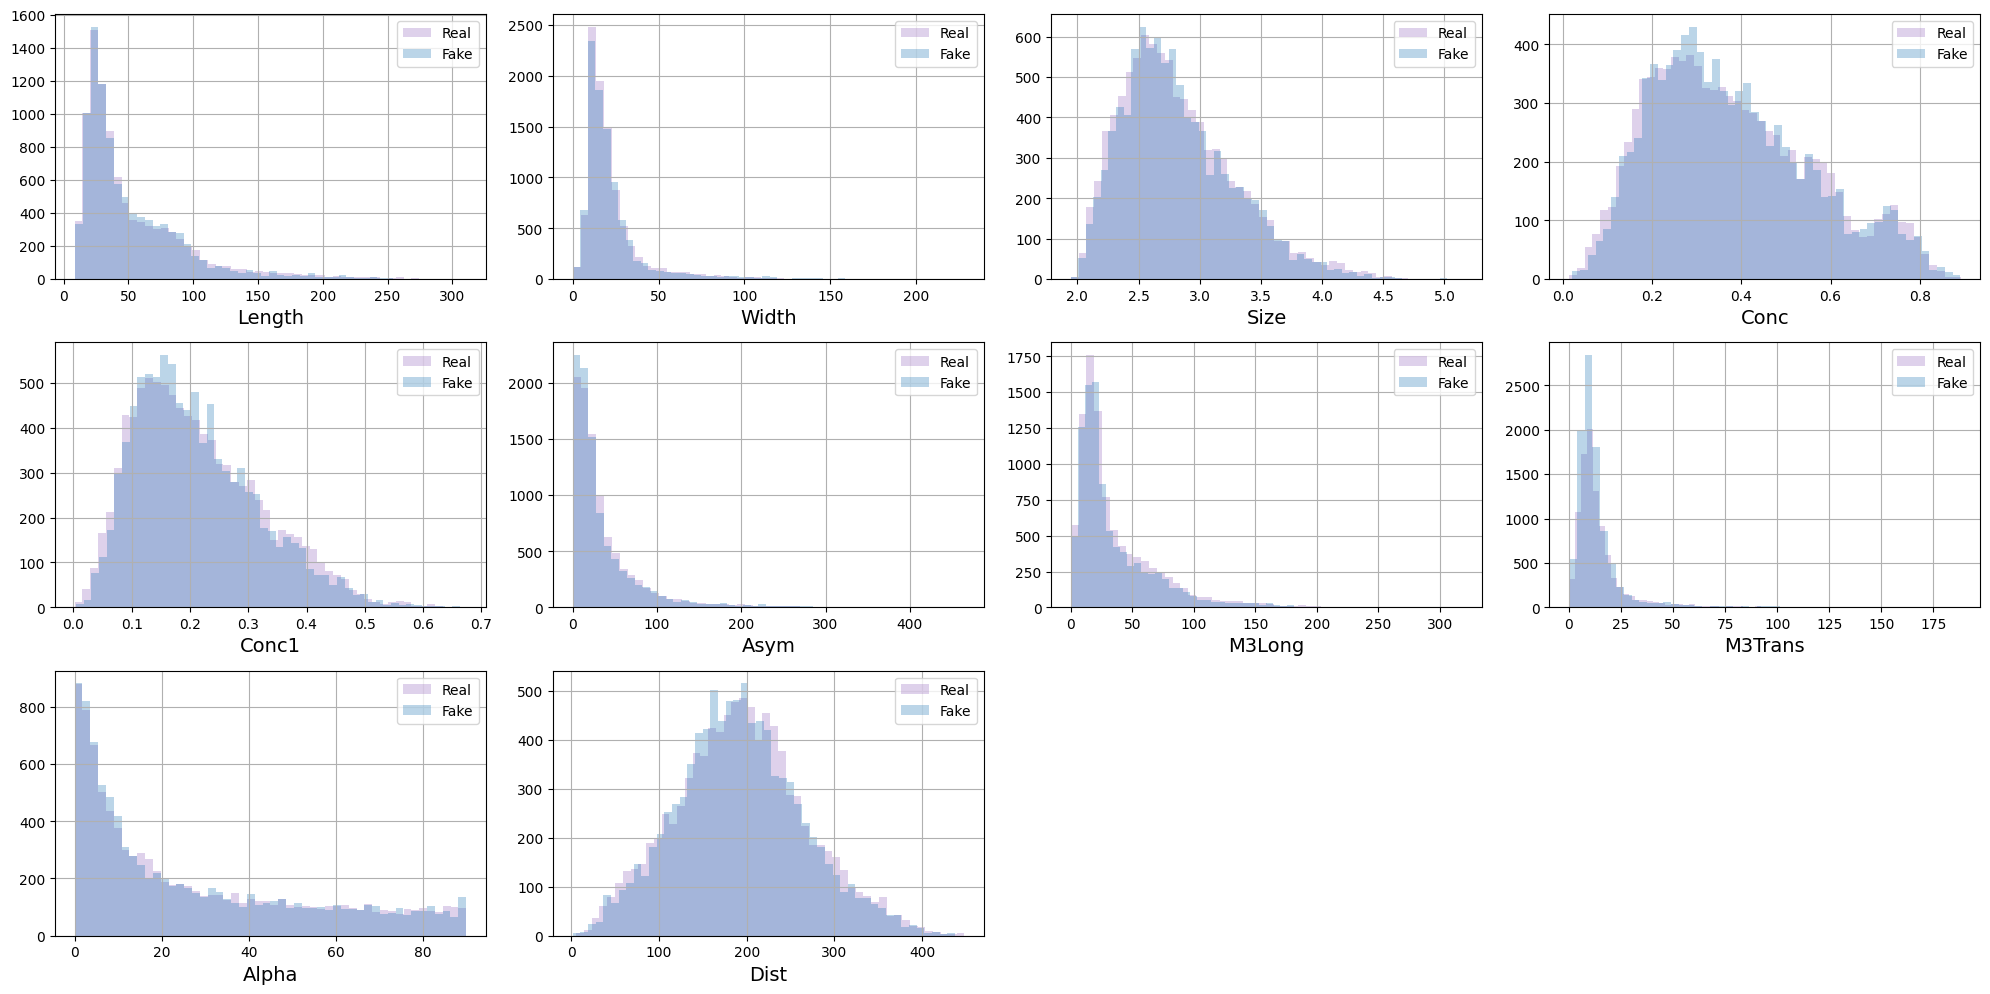

In [28]:
plot_hists(X_test, X_fake_test, names, label1="Real", label2="Fake", bins=50)

## Ответьте на вопросы:
- Похожи ли фейковые объекты на реальные?

Судя по графикам видно сходство реальных и фейковых данных

- Точно ли хорошая идея сравнивать их на глаз?

Не очень, так как эти графики - проекции 10-мерных объектов на одну ось.

# Измерение качества генерации

<center><img src="img/clf.png" width="600"></center>

Измерим сходство распределений классификатором.

In [29]:
# собираем реальный и фейковые матрицы в одну
XX_train = np.concatenate((X_fake_train, X_train), axis=0)
XX_test = np.concatenate((X_fake_test, X_test), axis=0)

yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train))
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test))

In [30]:
from sklearn.ensemble import GradientBoostingClassifier

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [31]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  0.7002645231484705


## Задание 9 (0.5 балла)

Опишите ваш эксперимент. Как вы оцениваете полученные результаты? Как вы думаете, какое значение ROC AUC нас удовлетворяет больше всего? Почему?

__Ответ:__ Мы использовали генератор для создания данных из шума, похожие на реальные. Затем мы обучали дискриминатор, чтобы он мог максимально точно отличать сгенерированные данные от реальных, а генератор обучался так, чтобы дискриминатор не мог различать данные. В тоге мы получили фейковые данные, распределение которых близко к настоящему. Для оценки качества использовали метрику ROC-AUC: идеальным результатом считалось значение 0.5, так как это означает, что классификатор не способен отличить реальные данные от сгенерированных.

## Диффузионные модели.

Давайте теперь проведем такой же экперимент с простой диффузионной моделью.

## Задание 10 (0.5 балла)

Воспользуйтесь [DDPMScheduler](https://huggingface.co/docs/diffusers/api/schedulers/ddpm), возьмите 1000 шагов и подумайте, надо ли указать ещё какой-то параметр.

__Подсказка__: Посмотрите на распределения выше и почитайте описание шедулера в документации. Один из параметров - наследие от использования в генерации картинок, а у нас не картинки.

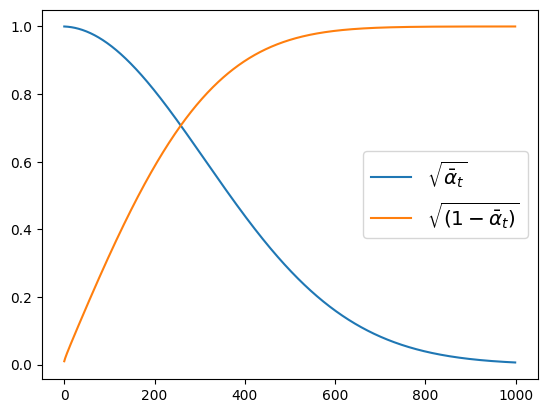

In [32]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
plt.plot(
    noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$"
)
plt.plot(
    (1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5,
    label=r"$\sqrt{(1 - \bar{\alpha}_t)}$",
)
plt.legend(fontsize="x-large")
plt.show()

## Задание 11 (0.5 балла)

Реализуйте нейронную сеть. В качестве архитектуры можете взять модель генератора. В процессе экспериментов попробуйте изменять архитектуру модели для улучшения качества сгенерированных объектов (Кстати, как вы будете качество измерять?).

- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [33]:
class DiffusionGenerator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(DiffusionGenerator, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, n_outputs),
        )

    def forward(self, z, t, y):
        zty = torch.cat((z, t, y), dim=1)
        return self.net(zty)

## Задание 12 (0.5 балла)

Напишите функцию для генерации нового объекта с помощью обученной модели.

In [34]:
def generate_with_diffusion(model, y, latent_dim, scheduler):
    y_tensor = torch.tensor(y, dtype=torch.float, device=DEVICE)
    if len(y_tensor.shape) == 1:
        y_tensor = y_tensor.unsqueeze(1)
    z = torch.randn(y_tensor.shape[0], latent_dim).to(DEVICE)
    timesteps = torch.randint(0, scheduler.config.num_train_timesteps, size=(y_tensor.shape[0],), device=DEVICE)
    timesteps = timesteps.unsqueeze(1)
    X_fake = model(z, timesteps, y_tensor)
    return X_fake.cpu().detach().numpy()

## Задание 13 (2 балла)

Напишите класс обучения диффузионной модели и обучите модель, после чего опишите полученные результаты. В качестве подсказки - опирайтесь на семинар по диффузионным моделям. Вы можете изменять некоторые части кода для вашего удобства, но оставляйте в таком случаи комментарии, пожалуйста.

In [35]:
QT = QuantileTransformer(output_distribution='normal', random_state=11)
X_train = QT.fit_transform(X_train)
X_test = QT.transform(X_test)

In [36]:
#взял из семинара
def corrupt(x: torch.Tensor, amount: torch.Tensor) -> torch.Tensor:
    """
    Corrupt the input `x` by mixing it with noise according to `amount`
    :param amount: torch.Tenosr of shape [x.shape[1], x.shape[2], x.shape[3]]
    """
    noise = torch.rand_like(x)
    amount = amount.view(-1, 1)
    return x * (1 - amount) + noise * amount

class DiffusionFitter(object):
    def __init__(
        self,
        model,
        batch_size=32,
        n_epochs=10,
        latent_dim=1,
        lr=0.0001,
        n_critic=5,
    ):

        self.model = model
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic

        self.opt_gen = torch.optim.RMSprop(self.model.parameters(), lr=self.lr)
        self.loss = nn.MSELoss()
        self.opt = torch.optim.Adam(model.parameters(), lr=1e-3)
        self.noise_scheduler = DDPMScheduler(num_train_timesteps=10000)

        self.model.to(DEVICE)

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.model.train(True)

        self.loss_history = []

        # Fit GAN
        for epoch in range(self.n_epochs):
            loss_epoch = 0
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):

                real_batch, cond_batch = real_batch.to(DEVICE), cond_batch.to(DEVICE)

                timesteps = torch.randint(0, self.noise_scheduler.config.num_train_timesteps, size = (real_batch.shape[0], ), device=DEVICE)
                noise_iters = self.noise_scheduler.add_noise(real_batch, torch.rand(real_batch.shape).to(DEVICE), timesteps)

                random_timesteps = torch.randint(0, 999, (real_batch.shape[0],)).long().to(DEVICE)
                random_timesteps = random_timesteps.unsqueeze(1)
                pred = self.model(noise_iters, random_timesteps, cond_batch)
                loss = self.loss(pred, real_batch)

                self.opt.zero_grad()
                loss.backward()
                self.opt.step()

                loss_epoch += loss.item()

            # caiculate and store loss after an epoch

            self.loss_history.append(loss_epoch)

            if epoch % 20 == 0:
                print('epoch:', epoch)
                idx = torch.randperm(X_real.shape[0])[:1000]
                noisy_x = corrupt(X_real[idx], torch.rand(X_real[idx].shape[0]).to(DEVICE))
                timesteps_1 = torch.randint(0, self.noise_scheduler.config.num_train_timesteps, size=(noisy_x.shape[0],), device=DEVICE)
                timesteps_1 = timesteps_1.unsqueeze(1)
                X_fake = self.model(noisy_x, timesteps_1, y_cond[idx])
                other_agent_score(X_real[idx].cpu().detach().numpy(), torch.ones(1000), X_fake.cpu().detach().numpy(), torch.zeros(1000))

        print('epoch:', epoch)
        idx = torch.randperm(X_real.shape[0])[:1000]
        noisy_x = corrupt(X_real[idx], torch.rand(X_real[idx].shape[0]).to(DEVICE))
        X_fake = self.model(noisy_x, timesteps_1, y_cond[idx])
        other_agent_score(X_real[idx].cpu().detach().numpy(), torch.ones(1000), X_fake.cpu().detach().numpy(), torch.zeros(1000))
        # Turn off training
        self.model.train(False)

Обучим модель на данных, указав количество входов.

У вас есть скрытое пространство и его размер, есть таймстепы и есть условие. Как легко догадаться, размер входа будет больше, чем просто размер скрытого пространства.

In [37]:
%%time
latent_dim = 10
model = DiffusionGenerator(n_inputs=latent_dim + y.shape[1] + 1, n_outputs=X_train.shape[1])

diffusionFitter = DiffusionFitter(
    model,
    batch_size=50,
    n_epochs=200,
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=5,
)
diffusionFitter.fit(X_train, y_train)

epoch: 0
Logistic regression score: 0.639
Boosting score: 0.987
epoch: 20
Logistic regression score: 0.54
Boosting score: 0.99
epoch: 40
Logistic regression score: 0.606
Boosting score: 0.989
epoch: 60
Logistic regression score: 0.614
Boosting score: 0.963
epoch: 80
Logistic regression score: 0.53
Boosting score: 0.948
epoch: 100
Logistic regression score: 0.502
Boosting score: 0.974
epoch: 120
Logistic regression score: 0.535
Boosting score: 0.93
epoch: 140
Logistic regression score: 0.553
Boosting score: 0.943
epoch: 160
Logistic regression score: 0.624
Boosting score: 0.946
epoch: 180
Logistic regression score: 0.58
Boosting score: 0.929
epoch: 199
Logistic regression score: 0.601
Boosting score: 0.925
CPU times: user 1min 55s, sys: 2.76 s, total: 1min 58s
Wall time: 2min 9s


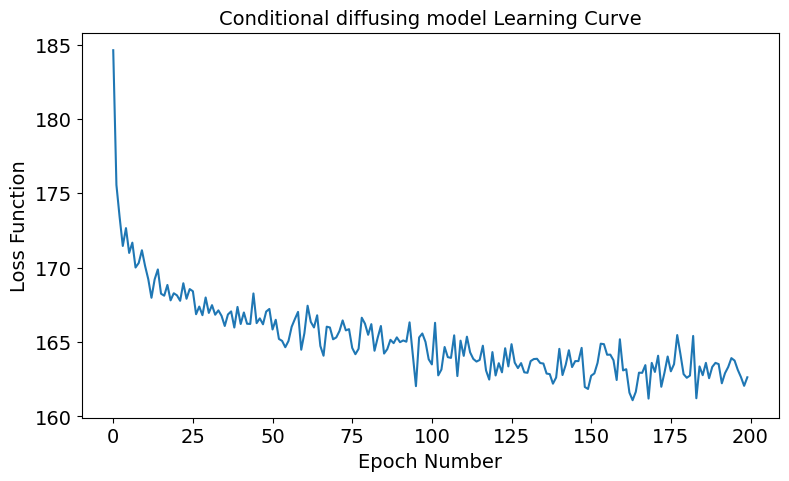

In [38]:
# diffusion learning curve
plt.figure(figsize=(9, 5))
plt.plot(diffusionFitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional diffusing model Learning Curve", size=14)
plt.show()

## Задание 14 (0.5 балла)
По аналогии с прошлым экспериментом с GAN моделью сгенерируйте выборку фейковых объектов равную размеру тестовой выборки и обучите градиентный бустинг. Обучите модель отличать реальные объекты от фейковых, после чего расчитайте метрики ROC-AUC и accuracy score. Какие получились результаты? Как вы их оцениваете? А в сравнении с GAN моделью?

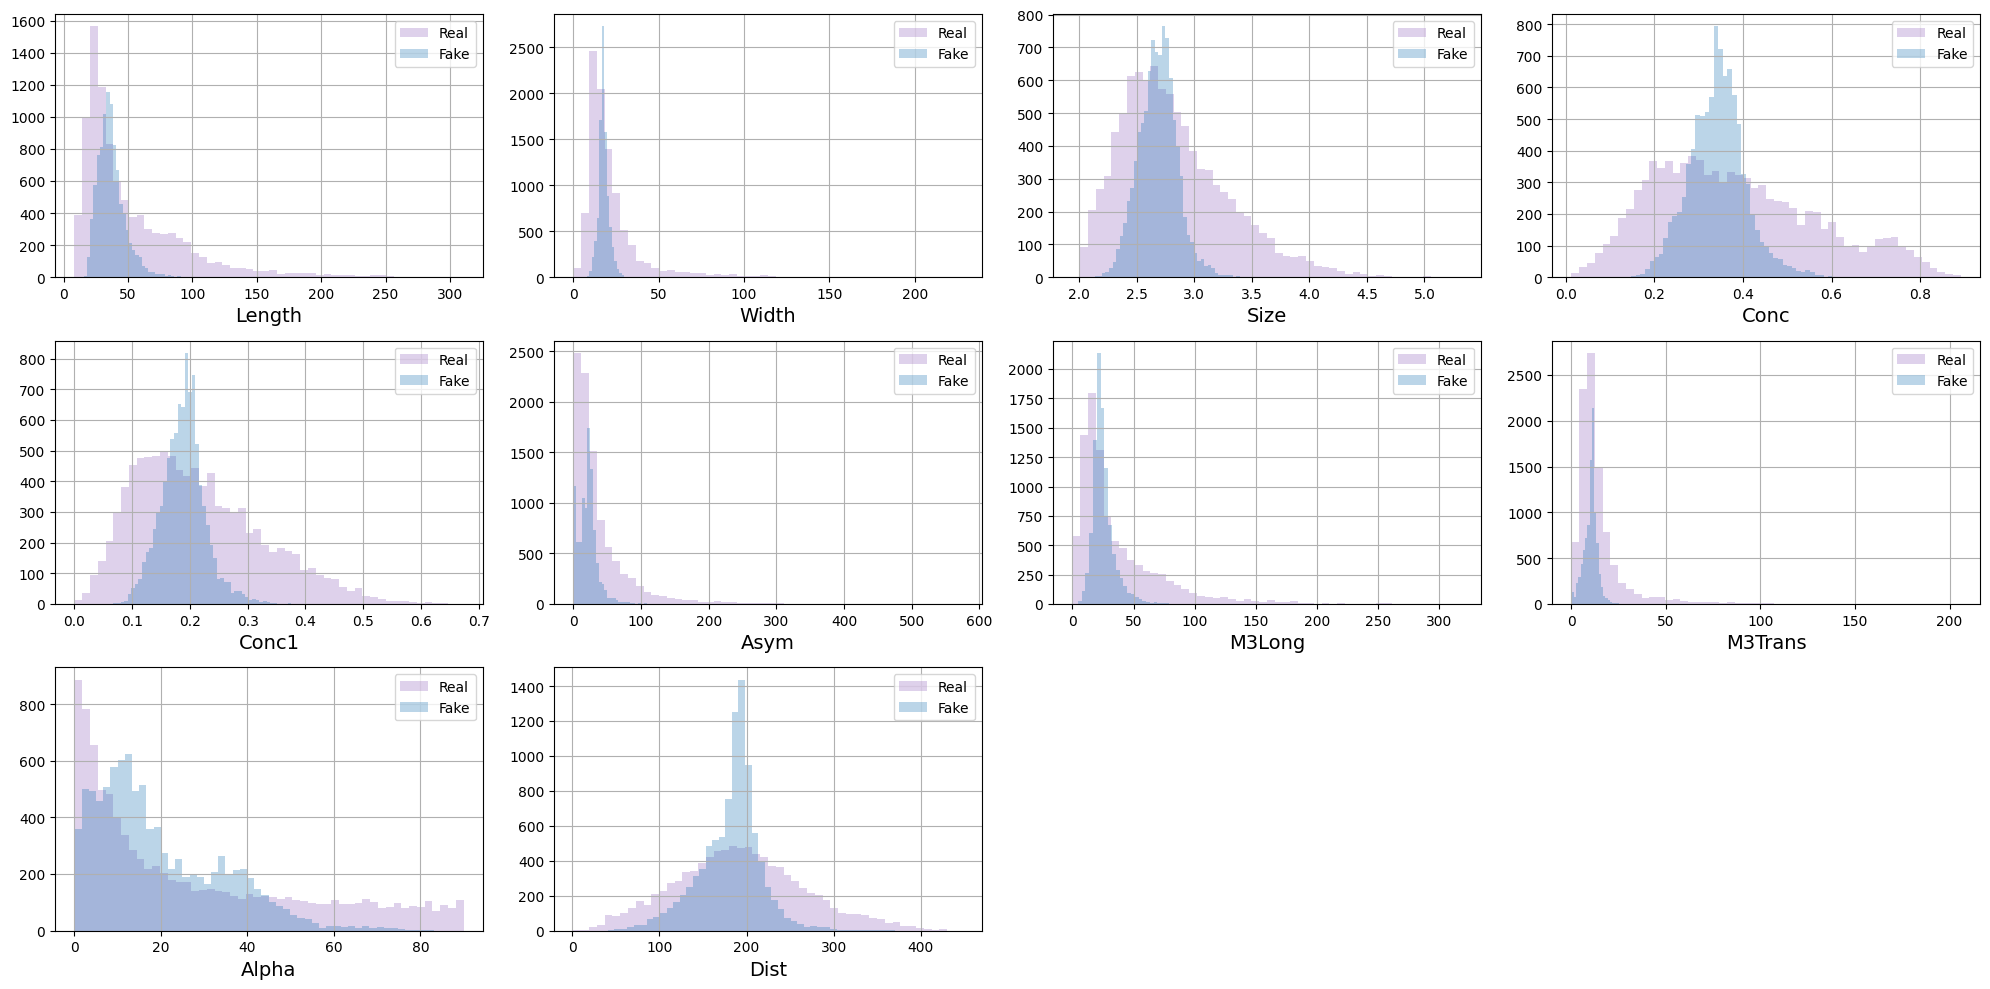

In [39]:
X_fake_train = generate_with_diffusion(diffusionFitter.model, y_train, latent_dim, noise_scheduler)
X_fake_test = generate_with_diffusion(diffusionFitter.model, y_test, latent_dim, noise_scheduler)

X_fake_train = QT.inverse_transform(X_fake_train)
X_fake_test = QT.inverse_transform(X_fake_test)
X_train = QT.inverse_transform(X_train)
X_test = QT.inverse_transform(X_test)

plot_hists(X_train, X_fake_train, names, label1="Real", label2="Fake", bins=50)

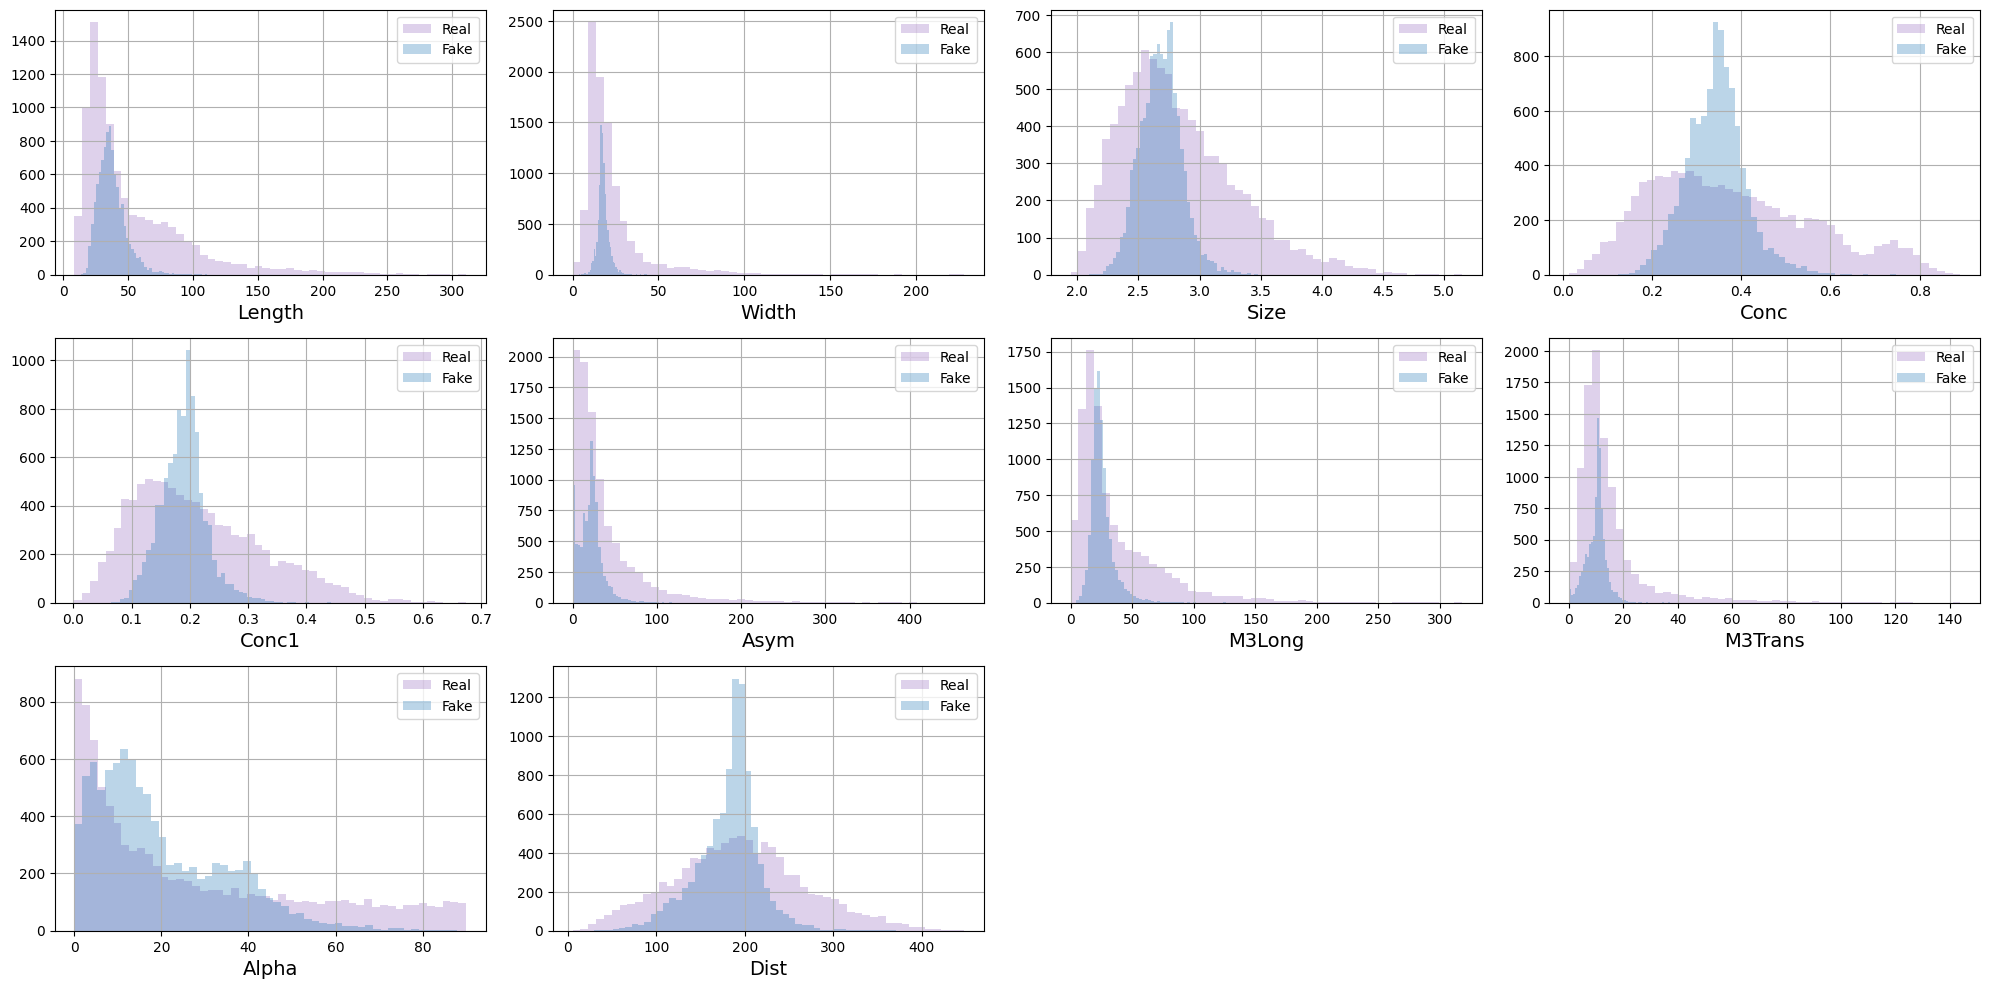

In [40]:
plot_hists(X_test, X_fake_test, names, label1="Real", label2="Fake", bins=50)

In [41]:
XX_train = np.concatenate((X_fake_train, X_train), axis=0)
XX_test = np.concatenate((X_fake_test, X_test), axis=0)

yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train))
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test))

clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]
yy_test_pred = clf.predict(XX_test)
roc_auc = roc_auc_score(yy_test, yy_test_proba)
accuracy = accuracy_score(yy_test, yy_test_pred)
print("ROC AUC = ", roc_auc)
print("Accuracy = ", accuracy)

ROC AUC =  0.9477458339829345
Accuracy =  0.8750262881177707


__Ответ:__ Возможно, я что-то сделал не так, но получилось не очень, а относительно GAN - плохо. Даже по этим графикам видно, что настоящие и сгенерированные вообще не сошлись;(

Из плюсов - обучилось быстрее в 1,5 раза, однако такая потеря в качестве не компенсируется выигранным временем)

Как я понял, диффузионка - оч сложная модель и в ней тяжелее подбирать параметры и она хуже обучается. А GAN относительно просто настроить (у меня сначала была генерация через равномерное распределение и был ROC-AUC 0.9, а потом сделал стандартное нормальное и получилось 0.7)

**Главный итог по этой домашке - GAN работает проще и дает более хороший результат, но работает дольше**

## Отзыв

Поздравляю! Вы дошли до конца. Оставьте ваш отзыв ячейкой ниже или отправьте его в канал курса, нам будет очень интересно!

__Ответ:__ Идея очень прикольная, WGAN классно справился и он понятен, а диффузионнки - что-то оч странное, как по мне.